### STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

### STEP 2. 추출된 결과로 embedding model 만들기

### STEP 3. target, attribute 단어 셋 만들기

이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다.

개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.

혹시 TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

### STEP 4. WEAT score 계산과 시각화

영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

### 데이터 로드

In [1]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(5):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.


### synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장

* 형태소 분석기 기능(Okt)
  * 1) morphs : 형태소 추출
  * 2) pos : 품사 태깅(Part-of-speech tagging)
  * 3) nouns : 명사 추출

In [2]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [3]:
print(len(tokenized))

71156


### word2vec 훈련 및 유사도 측정

* 여기서 Word2Vec의 하이퍼파라미터값은 다음과 같습니다.
  * size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
  * window = 컨텍스트 윈도우 크기
  * min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
  * workers = 학습을 위한 프로세스 수
  * sg = 0은 CBOW, 1은 Skip-gram.

In [4]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
#model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
#model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
model.most_similar(positive=['영화'])

/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('작품', 0.9156636595726013),
 ('다큐멘터리', 0.8760051131248474),
 ('드라마', 0.8386861085891724),
 ('코미디', 0.8124591112136841),
 ('스토리', 0.8044440150260925),
 ('형식', 0.799674391746521),
 ('영화로', 0.7983258962631226),
 ('전쟁영화', 0.7939595580101013),
 ('소재', 0.7919403910636902),
 ('주제', 0.791346549987793)]

In [5]:
model.wv.most_similar(positive=['사랑'])

[('진심', 0.7209908962249756),
 ('행복', 0.7145041227340698),
 ('연애', 0.7143678665161133),
 ('첫사랑', 0.7100784778594971),
 ('이별', 0.708541750907898),
 ('시빌라', 0.69657963514328),
 ('실연', 0.6946606636047363),
 ('토마슈', 0.6931048631668091),
 ('애정', 0.6920387148857117),
 ('고백', 0.6914018988609314)]

In [6]:
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.9027203321456909),
 ('데뷔', 0.8921502232551575),
 ('송년회', 0.8875746726989746),
 ('원표', 0.8845874667167664),
 ('무용', 0.8836402893066406),
 ('영감', 0.883478581905365),
 ('연기자', 0.883049488067627),
 ('시나리오', 0.878595232963562),
 ('예술가', 0.8773123621940613),
 ('오페라', 0.8754920959472656)]

* 영화 구분
  * synopsis_art.txt : 예술영화
  * synopsis_gen.txt : 일반영화(상업영화)
  * 그 외 독립영화 등으로 분류

* 장르 구분
  * synopsis_SF.txt: SF
  * synopsis_가족.txt: 가족
  * synopsis_공연.txt: 공연
  * synopsis_공포(호러).txt: 공포(호러)
  * synopsis_기타.txt: 기타
  * synopsis_다큐멘터리.txt: 다큐멘터리
  * synopsis_드라마.txt: 드라마
  * synopsis_멜로로맨스.txt: 멜로로맨스
  * synopsis_뮤지컬.txt: 뮤지컬
  * synopsis_미스터리.txt: 미스터리
  * synopsis_범죄.txt: 범죄
  * synopsis_사극.txt: 사극
  * synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
  * synopsis_성인물(에로).txt: 성인물(에로)
  * synopsis_스릴러.txt: 스릴러
  * synopsis_애니메이션.txt: 애니메이션
  * synopsis_액션.txt: 액션
  * synopsis_어드벤처.txt: 어드벤처
  * synopsis_전쟁.txt: 전쟁
  * synopsis_코미디.txt: 코미디
  * synopsis_판타지.txt: 판타지

### target 설정 및 불용어 처리

* okt.morphs     #형태소 분석
* okt.nouns      #명사 분석
* okt.phrases    #구(Phrase) 분석
* okt.pos        #형태소 분석 후 품사 태깅
  * print(okt.pos(u'이것도 되나욬ㅋㅋ'))
  * [('이', 'Determiner'), ('것', 'Noun'), ('도', 'Josa'), ('되나욬', 'Noun'), ('ㅋㅋ', 'KoreanParticle')]

In [7]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'
stop_word = ["위해", "자신", "사람", "그녀", "남자", "여자", "시작", "영화", "영화제"]# 불용어 정의
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                # word[1]에는 형태소태깅, word[0]에는 단어가 들어있음
                # TF-IDF로 처리되지 않고 여러 문장에 반복해서 나오는 단어들을 제거
                if word[1] in ["Noun"] and word[0] not in stop_word:#, "Adjective", "Verb"]:
                    
                    result.append((word[0])) 
    return ' '.join(result)

In [9]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


### TF-IDF를 활용하여 벡터화

In [10]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41073)


In [14]:
print(vectorizer.vocabulary_['가족'])
print(vectorizer.get_feature_names()[230])

230
가족


In [15]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
사랑, 친구, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 청년, 한국, 가지, 상처, 할머니, 목숨, 이상, 희망, 계획, 

일반영화를 대표하는 단어들:
국제, 친구, 사랑, 이야기, 대한, 서울, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 이후, 조직, 회사, 보고, 부산, 아빠, 부부, 일본, 문제, 

### target 확인

In [16]:
n = 15
w1_, w2_ = [], []


for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [17]:
# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [18]:
print(target_art)

['음악', '결심', '운명', '지금', '여인', '이름', '준비', '감정', '만난', '처음', '충격', '누구', '그린', '연인', '청년']


In [19]:
print("ART: ", target_art[:10])
print("GEN: ", target_gen[:10])

ART:  ['음악', '결심', '운명', '지금', '여인', '이름', '준비', '감정', '만난', '처음']
GEN:  ['서울', '애니메이션', '여성', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스']


### 불러올 데이터 설정

In [20]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [35]:
print(len(genre_txt), len(genre_name))

21 21


### 데이터 로드 후 corpus 생성

In [23]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42182)


In [25]:
print(w[0][:10])

### 장르별 단어 확인

In [26]:
# coo: 희소행렬을 데이터의 좌표만  표시
# m.row, m.col, m.data를 통해 0 아닌 원소의 좌표와 값에 접근
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)# count기반의 TF-IDF값을 기준으로 정렬
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()


SF: 지구, 인류, 인간, 미래, 우주, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 
가족: 엄마, 아빠, 가족, 친구, 아주르, 아버지, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 
공포(호러): 친구, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 좀비, 사실, 소녀, 하나, 살인, 이야기, 비밀, 
기타: 국제, 서울, 단편, 이야기, 사랑, 뉴미디어, 페스티벌, 대한, 독립, 친구, 작품, 엄마, 통해, 아시아나, 다른, 
다큐멘터리: 다큐, 국제, 다큐멘터리, 이야기, 대한, 감독, 서울, 우리, 세계, 통해, 여성, 가족, 한국, 작품, 환경, 
드라마: 사랑, 국제, 친구, 이야기, 엄마, 아버지, 가족, 단편, 서울, 대한, 아들, 마음, 아이, 남편, 서로, 
멜로로맨스: 사랑, 남편, 친구, 섹스, 마음, 결혼, 서로, 아내, 관계, 부부, 엄마, 아버지, 사실, 점점, 다시, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 음악, 충무로, 모차르트, 토스카, 니웨, 카바, 바흐, 페뷔스, 프롤, 모도, 카르피, 제루샤, 
미스터리: 사건, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 아이, 민혁, 사실, 의문, 미스터리, 형사, 
범죄: 사건, 경찰, 범죄, 조직, 살인, 마약, 형사, 모든, 살해, 수사, 발견, 한길수, 범인, 계획, 은행, 
사극: 조선, 신기전, 사랑, 아가멤논, 황제, 루안, 최고, 운명, 하선, 전쟁, 윤서, 트로이, 세자, 허균, 노준, 
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 개릿, 아이, 무법자, 프린트, 마적, 태구, 현상금, 분노, 
성인물(에로): 남편, 마사지, 섹스, 관계, 정사, 유부녀, 마음, 사랑, 에피소드, 그린, 아내, 다시, 자위, 이야기, 회사, 
스릴러: 

### 4. embedding model과 단어 셋으로 WEAT score 구해보기

이제 WEAT_score를 구해봅시다.

traget_A는 art, target_B는 gen, attribute_X는 '드라마', attribute_Y는 '액션' 과 같이 정해줄 수 있습니다.

target_A 는 art, target_B 는 gen으로 고정하고 attribute_X, attribute_Y를 바꿔가면서 구해봅시다.

구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담아봅시다.

In [27]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [28]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B#, c_a, c_b

# print(s(attribute_X['사랑'], A, B))

In [29]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

# print(round(weat_score(X, Y, A, B), 3))

In [30]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

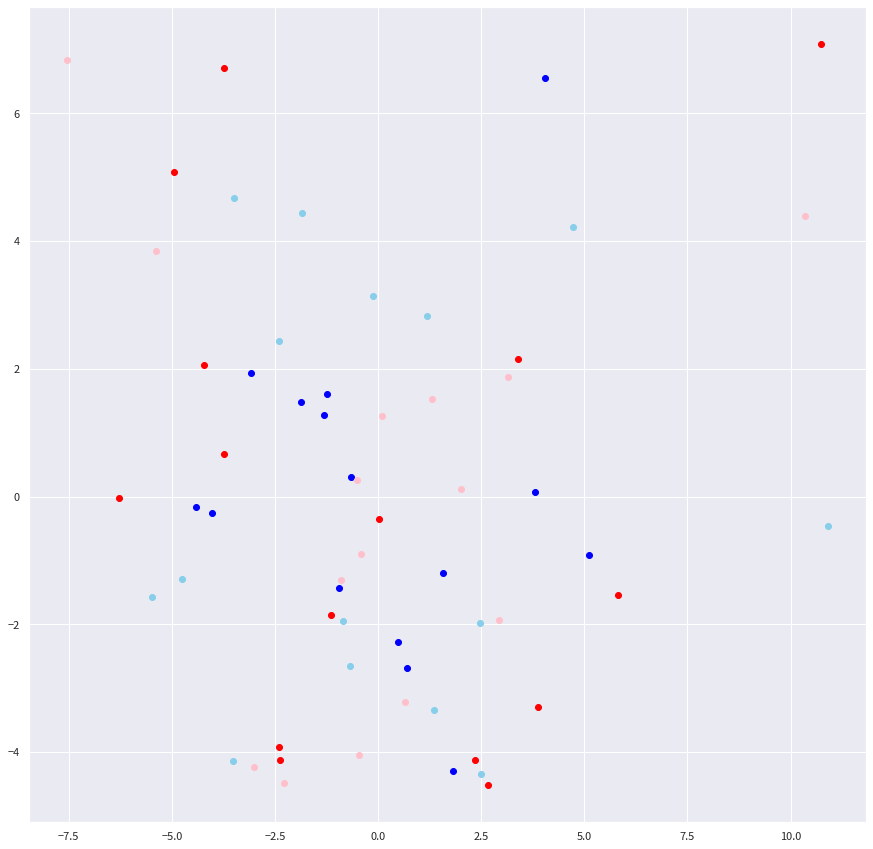

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

### heatmap으로 matrix 시각화

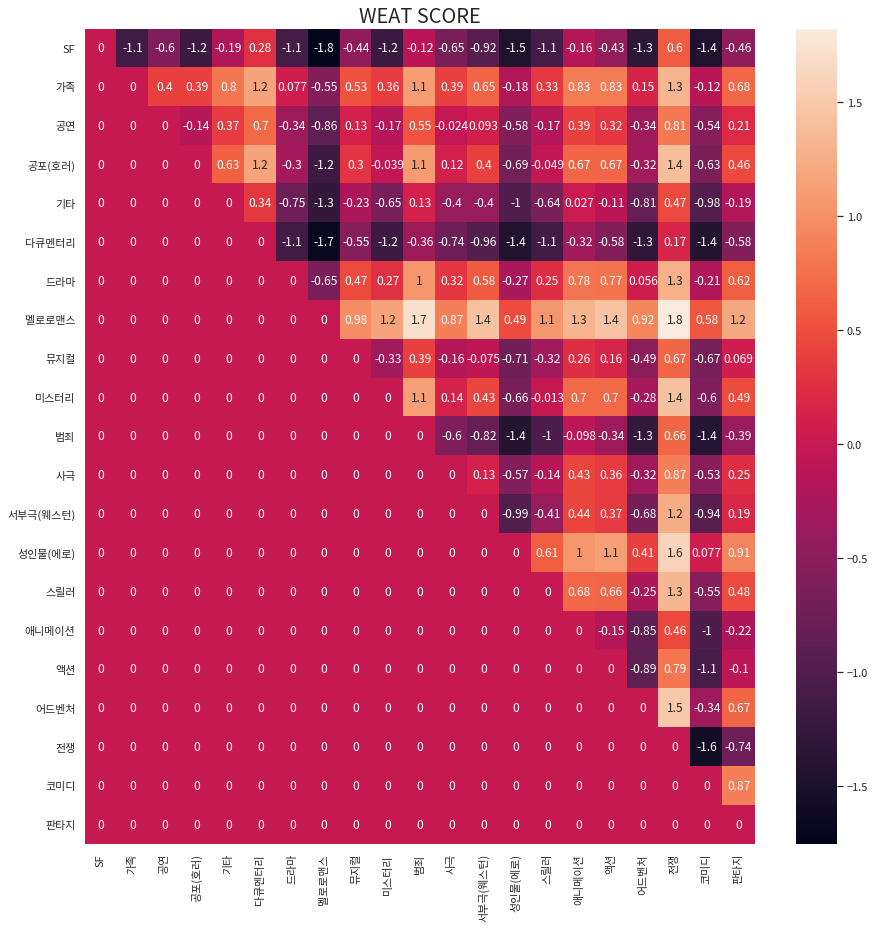

<AxesSubplot:title={'center':'WEAT SCORE'}>

In [31]:
import matplotlib.pylab as plt
import seaborn as sns

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

plt.rcParams['figure.figsize'] = (15, 15)
ax = sns.heatmap(matrix, xticklabels=genre_name,
                 yticklabels=genre_name, annot=True)
plt.title('WEAT SCORE', fontsize=20)

plt.show()
ax

## 루브릭

1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.

* 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔습니다.

2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.

* TF-IDF로 제거되지 않고 반복적으로 나오는 단어를 처리하기 위해 불용어 사전을 만들어 구분을 방해하는 단어 제거하였습니다.

3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.

* 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였습니다.


## 회고

이번 노드에서 가장 시간이 오래 걸린 부분은 평가 지표를 이해하는 부분이었습니다. 우선 TF-IDF로 처리되지 않은 여러 카테고리에서 반복적으로 출력되는 단어들을 제거하기 위한 방식을 생각해 봤습니다. TF-IDF는 빈도 기반이며 특정 카테고리 내에서 많이 관찰되는 단어에 가중치를 주고, 모든 문서에서 반복적으로 등장하는 단어는 역가중치를 주어 단순 빈도 기반의 문제점을 개선하고자 하였습니다. 이를 보완하기 위한 방법으로 LSA나 LDA 방식이 특정 토픽을 대표하는 단어를 출력하는 데 보다 효과적일것이라고 생각해 해당 방식을 도입하려 하였습니다. 그러나 토픽 모델링의 경우, 추출한 토픽의 이름이나 카테고리를 알 수 있는게 아니라 새롭게 네이밍 하고 해석해야 한다는 점에서 방향이 잘못되었다고 생각해 해당 방식을 사용하지 못하고, 불용어 사전을 만들어 여러 문서에서 반복 등장하는 몇가지 단어만 제거하여 의미 있는 분류가 되게 만들었습니다.

이 부분을 제외한 나머지는 코드가 주어졌기 때문에 크게 어렵지 않았지만, 노드에서는 단어에 편향은 좋지 않은것처럼 설명이 되어 있었는데 결국 편향을 극대화하여 주제를 잘 설명할 수 있는 단어를 추출하는것이 프로젝트로 나와 약간의 괴리감이 있었습니다.